In [115]:
import pandas as pd
import re
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.utils import resample
import string
from collections import Counter
warnings.filterwarnings('ignore')
nltk.download("punkt_tab")
nltk.download("stopwords")

[nltk_data] Downloading package punkt_tab to /Users/lila/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/lila/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Cel biznesowy

Celem naszego projektu jest wprowadzenie automatycznej moderacji komentarzy w celu wykrywania krytyki i problemów, umożliwiając twórcy szybkiej reakcji na negatywne opinie, poprawę jakości interakcji pod filmem oraz redukcja hejtu, czy spamu.

Model, który w tym celu tworzymy na podstawie treści komentarzy będzie skutecznie klasyfikował je na komentarze negatywne oraz pozytywne i neutralne. 

Będzie to model charakteryzujący się:
- dobrą precyzją (tak aby za dużo pozytywnych komentarzy nie było usuwanych i filmy lub twórca nie traciły na popularności)
- wysoką czułością (zależy nam na wykryciu możliwie wszystkich negatywnych komentarzy).

Koszty błędów modelu:
- FN(False Negative) – źle wykryty negatywny komentarz (złe samopoczucie użytkowników, złe skojarzenia z marką lub twórcą, firma może zostać oskarżona o niedbałość jeśli nie odpowiada na negatywne komentarze).
- FP(False Positive) – źle wykryty pozytywny lub neutralny komentarz (utrata pozytywnych opinii, mniejsza popularność filmu).

Nacisk chcemy położyć przede wszystkim na prawidłowe wykrywanie negatywnych komentarzy, ponieważ konsekwencje z ich niepoprawnym wykryciem są nieporównywalnie gorsze od złego wykrywania pozytywnych. Zatem naszym priorytetem jest zminimalizowanie wielkości FN. 

# Data cleaning -- getting rid of null values and duplicates

In [116]:
data = pd.read_csv("YoutubeCommentsDataSet.csv")

data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18408 entries, 0 to 18407
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Comment    18364 non-null  object
 1   Sentiment  18408 non-null  object
dtypes: object(2)
memory usage: 287.8+ KB


,Comment,Sentiment
count,18364,18408
unique,17871,3
top,one of the best thing about dude is that he ne...,positive
freq,10,11432


Splitting into train, test, val

In [117]:
from sklearn.model_selection import train_test_split

# First, split the dataset into train (70%) and temp (30%)
train_df, temp_df = train_test_split(data, test_size=0.3, stratify=data['Sentiment'], random_state=42)

# Then, split temp into validation (70%) and test (30%)
val_df, test_df = train_test_split(temp_df, test_size=0.3, stratify=temp_df['Sentiment'], random_state=42)

# Print sizes
print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")


Train size: 12885, Validation size: 3866, Test size: 1657


In [118]:
df = train_df

In [119]:
print("\nNULL count:")
print(df.isnull().sum())
print()

print("Unique rows:", df["Comment"].nunique())
print("Duplicate rows:", df.duplicated().sum())

duplicated_comments = df[df.duplicated()]

print("Unique values in duplicated comments: ", duplicated_comments["Comment"].nunique())


NULL count:
Comment      38
Sentiment     0
dtype: int64

Unique rows: 12600
Duplicate rows: 281
Unique values in duplicated comments:  178


In [120]:
df.head()

,Comment,Sentiment
15073,the announcer here and on the direct is so goo...,positive
4520,chaturanga chatur means 4 anga means a partdiv...,positive
7549,well you should have appreciated how much effo...,positive
4097,to be friends with soup timmy you have to be g...,neutral
4921,my day instantly gets better whenever sam uplo...,positive


Poniewaz brakujących wartości jest bardzo mało i nie mają one wartości Sentiment, uznałyśmy, ze nie ma przeszkód by je usunąć

W celu uniknięcia overfitting usunęłyśmy take wartości zduplikowane (nie dają one więcej informacji modelowi)

In [121]:
#Discard empty entries (44/18408) and duplicates (?)
df = df.dropna()
df = df.drop_duplicates()

# Adding features
- Sentiment_Score_nltk (ciągły wskaźnik sentymentu komentarza o warotściach [-1, 1])
- Comment_length (długość komentarza)
- Starts_with_i - czy komentarz zaczyna się od I 
- Personal_Pronoun_count - liczba zaimków osobowych, takich jak he, she, i, etc.
- Number_of_phrases (czyli podział komentarza według spójników "but", "and", "because")
- Avg_phrase_length (średnia długość frazy)
- Number_of_words (liczba słów)
- Avg_word_length (średnia długość słów)
- Unique_word_ratio (stosunek liczby unikalnych słów do wszystkich słów, im większa tym bardziej rozbudowane słownictwo)

In [122]:
import nltk

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lila/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [123]:
#Dodajemy feature: Sentiment Score ntlk -- ciągły sentyment, wart. od -1 do 1.

sia = SentimentIntensityAnalyzer()
df['Sentiment_Score_nltk'] = df['Comment'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [124]:
#Dodajemy feature Starts_with_I
df['Starts_with_i'] = df['Comment'].str.startswith("i")
#Dodajemy feature Comment_Length
df['Comment_Length'] = df['Comment'].str.len()
#Mapowanie sentymentu 
sentiment_mapping = {'negative': -1, 'neutral': 0, 'positive': 1}
df['Sentiment_num'] = df['Sentiment'].map(sentiment_mapping)

In [125]:
#Tworzenie zmiennej Personal_Pronoun_Count
personal_pronouns = {"i", "me", "my", "mine", "myself", "we", "us", "our", "ours", "ourselves",
                     "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself",
                     "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their",
                     "theirs", "themselves"}
def count_personal_pronouns(comment):
    words = word_tokenize(comment.lower())
    return sum(1 for word in words if word in personal_pronouns)
    
df["Personal_Pronoun_count"] = df["Comment"].apply(lambda x: count_personal_pronouns(x))

In [126]:
#Tworzenie zmiennych Number_of_phrases, Number_of_words, Avg_phrase_length, Avg_word_length, Unique_word_ratio
connectors = ["and", "but", "so", "because", "which", "that", "then", "if", "or"]
def sentence_complexity(comment):
    words = word_tokenize(comment)
    phrases = re.split(r'\b(?:' + '|'.join(connectors) + r')\b', comment)

    num_words = len(words)
    num_phrases = len(phrases)

    avg_word_length = np.mean([len(word) for word in words]) if words else 0
    avg_phrase_length = num_words / num_phrases if num_phrases > 0 else 0
    unique_word_ratio = len(set(words)) / num_words if num_words > 0 else 0

    return {
        "Number_of_phrases": num_phrases,
        "Number_of_words": num_words,
        "Avg_phrase_length": avg_phrase_length,
        "Avg_word_length": avg_word_length,
        "Unique_word_ratio": unique_word_ratio
    }

df_complexity = df["Comment"].apply(lambda x: sentence_complexity(x))
df_complexity = pd.DataFrame(df_complexity.tolist())
df = df.reset_index(drop=True)
df_complexity = df_complexity.reset_index(drop=True)
df = pd.concat([df, df_complexity], axis = 1)

In [127]:
df.head()

,Comment,Sentiment,Sentiment_Score_nltk,Starts_with_i,Comment_Length,Sentiment_num,Personal_Pronoun_count,Number_of_phrases,Number_of_words,Avg_phrase_length,Avg_word_length,Unique_word_ratio
0,the announcer here and on the direct is so goo...,positive,0.9094,False,353,1,8,9,80,8.888889,3.500000,0.712500
1,chaturanga chatur means 4 anga means a partdiv...,positive,0.4588,False,82,1,0,1,13,13.000000,5.307692,0.769231
2,well you should have appreciated how much effo...,positive,0.8816,False,104,1,3,3,21,7.000000,4.000000,0.952381
3,to be friends with soup timmy you have to be g...,neutral,0.8126,False,72,0,1,1,15,15.000000,3.866667,0.866667
4,my day instantly gets better whenever sam uplo...,positive,0.2732,False,156,1,4,1,27,27.000000,4.777778,0.925926


# Data exploration

In [128]:
from langdetect import detect, DetectorFactory, LangDetectException

# Set seed for consistency
DetectorFactory.seed = 0  

def safe_detect(text):
    try:
        return detect(text) if isinstance(text, str) and len(text.strip()) > 1 else 'unknown'
    except LangDetectException:
        return 'unknown'

df['language'] = df['Comment'].apply(safe_detect)


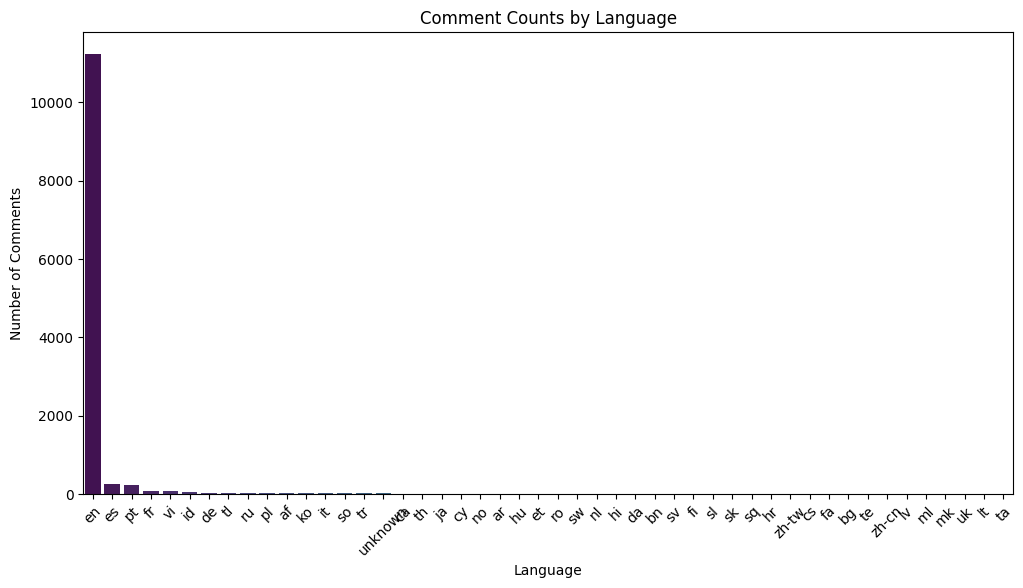

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of comments per language
language_counts = df['language'].value_counts()

# Convert to DataFrame for plotting
language_counts_df = language_counts.reset_index()
language_counts_df.columns = ['Language', 'Count']

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=language_counts_df, x='Language', y='Count', palette='viridis')

# Add labels and title
plt.xlabel('Language')
plt.ylabel('Number of Comments')
plt.title('Comment Counts by Language')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Show the plot
plt.show()


In [130]:
df = df[df['language']=='en']

### Most common words

[nltk_data] Downloading package stopwords to /Users/lila/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


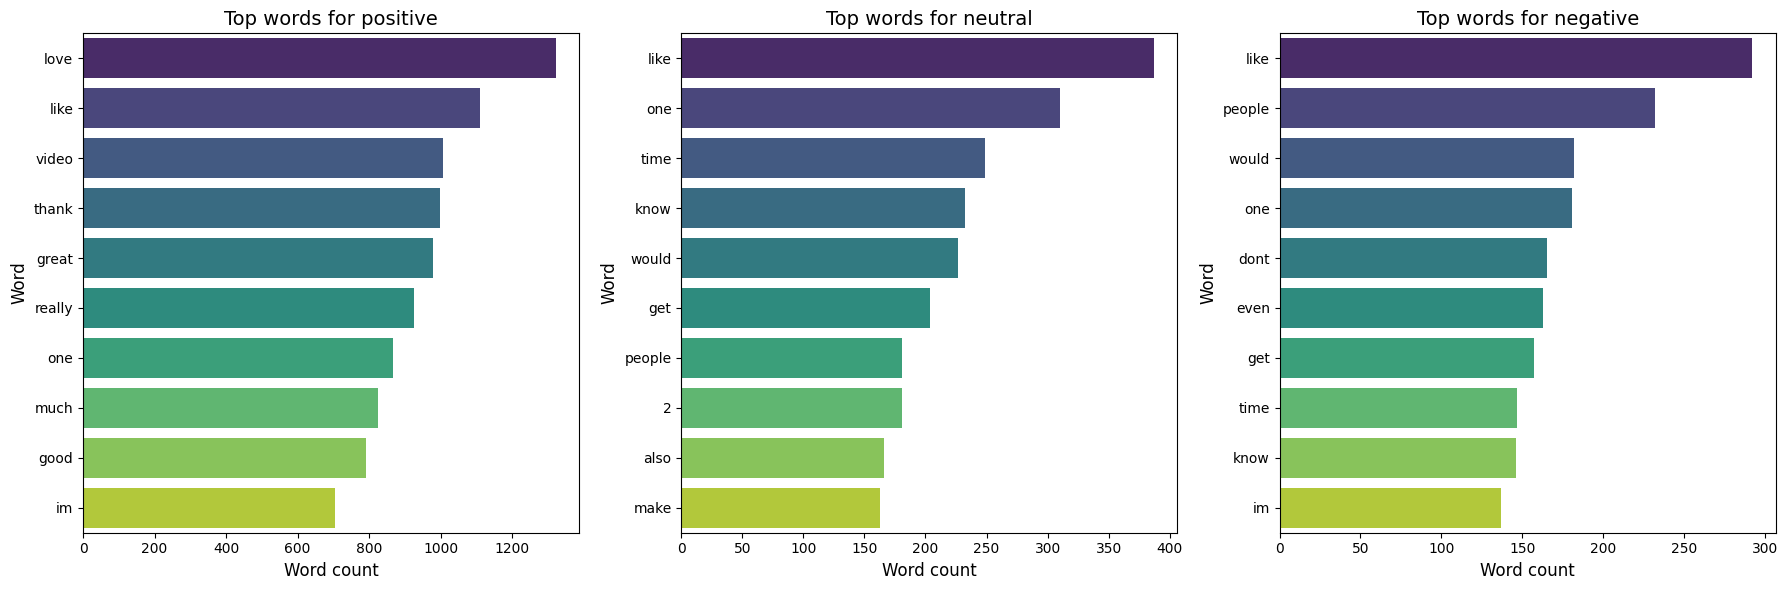

In [131]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to get the top 10 most common words for a given sentiment
def get_most_common_words(df, sentiment, top_n=10):
    text = " ".join(df[df['Sentiment'] == sentiment]['Comment'])
    words = text.lower().translate(str.maketrans("", "", string.punctuation)).split()
    words = [word for word in words if word not in stop_words]
    counter = Counter(words)
    return counter.most_common(top_n)

# Create plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, sentiment in enumerate(['positive', 'neutral', 'negative']):
    words, counts = zip(*get_most_common_words(df, sentiment))

    sns.barplot(x=list(counts), y=list(words), ax=axes[i], palette='viridis')
    axes[i].set_title(f"Top words for {sentiment}", fontsize=14)
    axes[i].set_xlabel("Word count", fontsize=12)
    axes[i].set_ylabel("Word", fontsize=12)

plt.tight_layout()
plt.show()

## Feature distributions

In [132]:
df.describe()

,Sentiment_Score_nltk,Comment_Length,Sentiment_num,Personal_Pronoun_count,Number_of_phrases,Number_of_words,Avg_phrase_length,Avg_word_length,Unique_word_ratio
count,11221.000000,11221.000000,11221.000000,11221.000000,11221.000000,11221.000000,11221.000000,11221.000000,11221.000000
mean,0.433650,185.938597,0.510293,3.427858,3.013368,35.281615,12.530740,4.315109,0.891287
std,0.480204,255.070757,0.731763,4.845849,3.218623,46.956427,10.721263,0.618025,0.105345
min,-0.997300,4.000000,-1.000000,0.000000,1.000000,1.000000,1.000000,1.714286,0.193878
25%,0.000000,72.000000,0.000000,1.000000,1.000000,14.000000,8.000000,3.923077,0.828571
50%,0.599400,120.000000,1.000000,2.000000,2.000000,23.000000,11.000000,4.267857,0.909091
75%,0.831600,211.000000,1.000000,4.000000,4.000000,40.000000,15.000000,4.647059,1.000000
max,0.999800,6031.000000,1.000000,120.000000,83.000000,1156.000000,479.000000,9.666667,1.000000


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11221 entries, 0 to 12599
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Comment                 11221 non-null  object 
 1   Sentiment               11221 non-null  object 
 2   Sentiment_Score_nltk    11221 non-null  float64
 3   Starts_with_i           11221 non-null  bool   
 4   Comment_Length          11221 non-null  int64  
 5   Sentiment_num           11221 non-null  int64  
 6   Personal_Pronoun_count  11221 non-null  int64  
 7   Number_of_phrases       11221 non-null  int64  
 8   Number_of_words         11221 non-null  int64  
 9   Avg_phrase_length       11221 non-null  float64
 10  Avg_word_length         11221 non-null  float64
 11  Unique_word_ratio       11221 non-null  float64
 12  language                11221 non-null  object 
dtypes: bool(1), float64(4), int64(5), object(3)
memory usage: 1.1+ MB


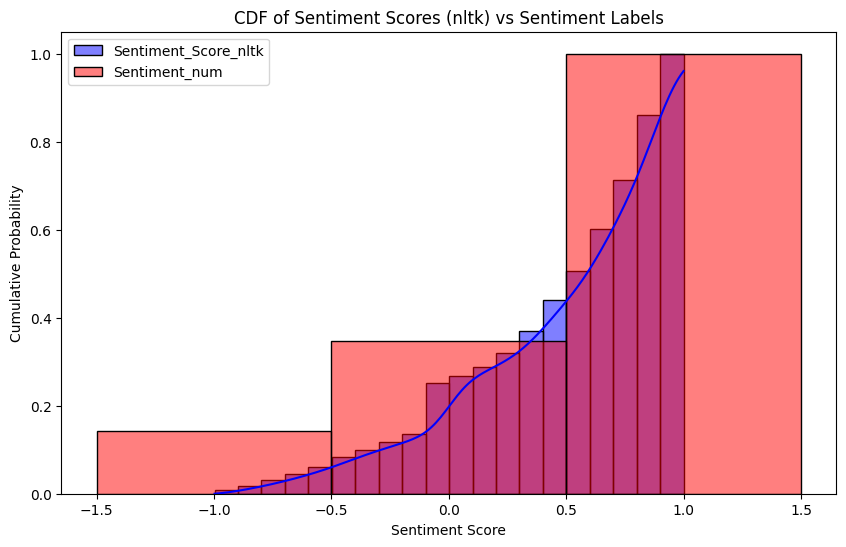

In [134]:
plt.figure(figsize=(10, 6))

# CDF for Sentiment_Score_nltk (continuous)
sns.histplot(df['Sentiment_Score_nltk'], bins=20, stat='density', cumulative=True, kde=True, color='blue', label='Sentiment_Score_nltk', alpha=0.5)

# CDF for Sentiment_num (discrete)
sns.histplot(df['Sentiment_num'], discrete=True, stat='density', cumulative=True, color='red', label='Sentiment_num', alpha=0.5)

# Labels and legend
plt.xlabel("Sentiment Score")
plt.ylabel("Cumulative Probability")
plt.title("CDF of Sentiment Scores (nltk) vs Sentiment Labels")
plt.legend()
plt.show()

### Rozkład zmiennej "Sentiment"

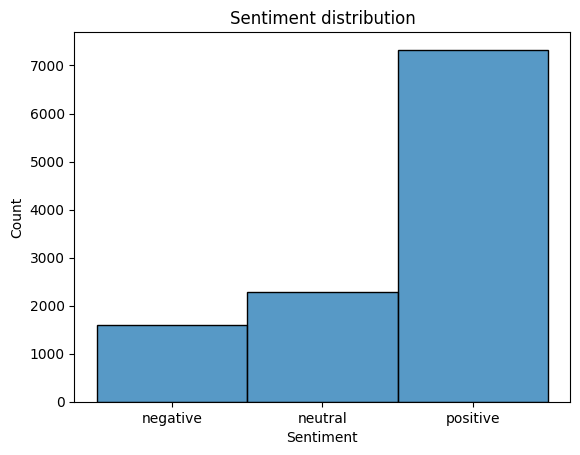

In [135]:
sentiment_order = ["negative", "neutral", "positive"]
df['Sentiment'] = pd.Categorical(df['Sentiment'], categories=sentiment_order, ordered=True)
sentiments = sns.histplot(df['Sentiment'])

sentiments.set_title("Sentiment distribution")
plt.show()

## Badanie zmiennej "Comment_Length"

### Rozkład "Comment_Length" w podziale na sentyment

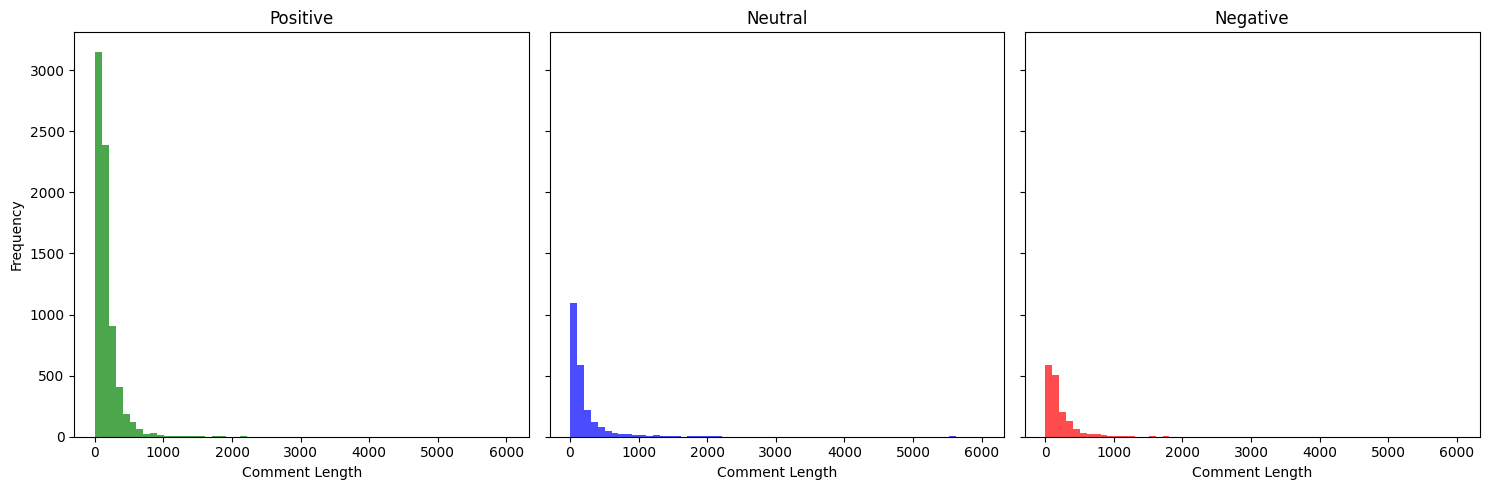

In [136]:
# Podział danych według sentymentu
positive = df[df['Sentiment'] == 'positive']
negative = df[df['Sentiment'] == 'negative']
neutral = df[df['Sentiment'] == 'neutral']

# Wyznaczenie wspólnego zakresu dla osi X
min_length = df['Comment_Length'].min()
max_length = df['Comment_Length'].max()

# Tworzenie figure i subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Histogram dla pozytywnych komentarzy
axes[0].hist(positive['Comment_Length'], bins=60, color='green', alpha=0.7, range=(min_length, max_length))
axes[0].set_title('Positive')
axes[0].set_xlabel('Comment Length')
axes[0].set_ylabel('Frequency')

# Histogram dla neutralnych komentarzy
axes[1].hist(neutral['Comment_Length'], bins=60, color='blue', alpha=0.7, range=(min_length, max_length))
axes[1].set_title('Neutral')
axes[1].set_xlabel('Comment Length')

# Histogram dla negatywnych komentarzy
axes[2].hist(negative['Comment_Length'], bins=60, color='red', alpha=0.7, range=(min_length, max_length))
axes[2].set_title('Negative')
axes[2].set_xlabel('Comment Length')

# Optymalizacja wyglądu
plt.tight_layout()
plt.show()

In [137]:
df.groupby('Sentiment')['Comment_Length'].agg(['mean', 'median', 'std','max','min'])

,mean,median,std,max,min
Sentiment,,,,,
negative,210.418227,136.0,258.904136,3775,17
neutral,217.151899,111.0,370.058760,6031,9
positive,170.828603,119.0,203.759714,5487,4


Widać, że komentarze negatywne mają najwyższą średnią. Komentarze neutralne są najbardziej zróżnicowane pod kątem długości, a komentarze pozytywne najmniej. Pozytywne komentarze w większości są krótkie i zwięzłe co może sugerować, że ludzie mniej się rozpisują, gdy wyrażają swoją aprobatę, natomiast dłużej, gdy coś im się nie podoba. Komentarze neutralne objemują zarówno krótkie, jak i rozbudowane analizy. Można zauważyć, że najdłuższe komentarze napisane przez użytkowników są neutralne.


### Rozkład "Comment_Length" dla całości

<Axes: xlabel='Comment_Length', ylabel='Count'>

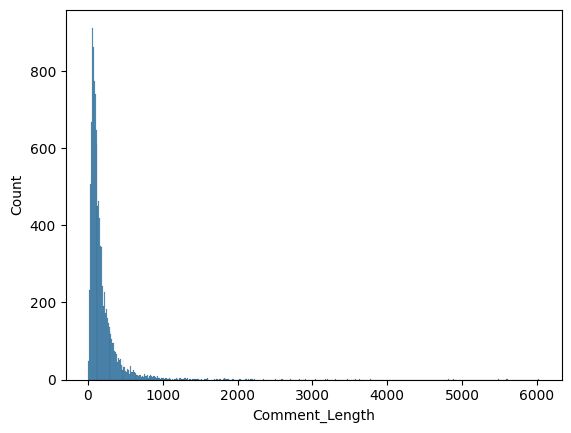

In [138]:
sns.histplot(df['Comment_Length'])

In [139]:
df['Comment_Length'].describe()

count    11221.000000
mean       185.938597
std        255.070757
min          4.000000
25%         72.000000
50%        120.000000
75%        211.000000
max       6031.000000
Name: Comment_Length, dtype: float64

### Zastępowanie wartości odstających 

<Axes: xlabel='Comment_Length_Clipped', ylabel='Count'>

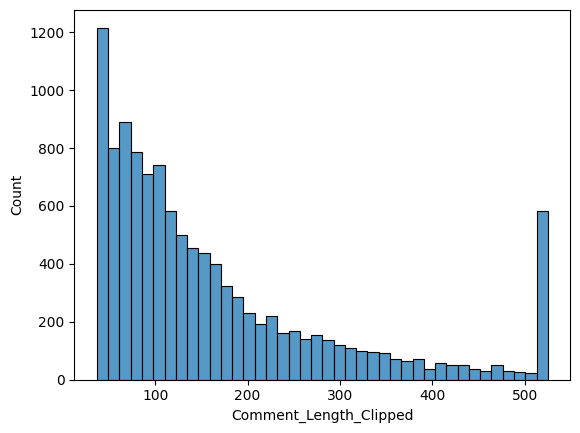

In [140]:
upper_lim = df['Comment_Length'].quantile(.95)
lower_lim = df['Comment_Length'].quantile(.05)

# Tworzenie nowej kolumny z obciętymi wartościami
df['Comment_Length_Clipped'] = df['Comment_Length'].clip(lower=lower_lim, upper=upper_lim)


sns.histplot(df['Comment_Length_Clipped'])

In [141]:
df.groupby('Sentiment')['Comment_Length_Clipped'].agg(['mean', 'median', 'std', 'max', 'min'])

,mean,median,std,max,min
Sentiment,,,,,
negative,185.513109,136.0,137.997163,525,37
neutral,170.842863,111.0,147.147345,525,37
positive,159.063592,119.0,121.198575,525,37


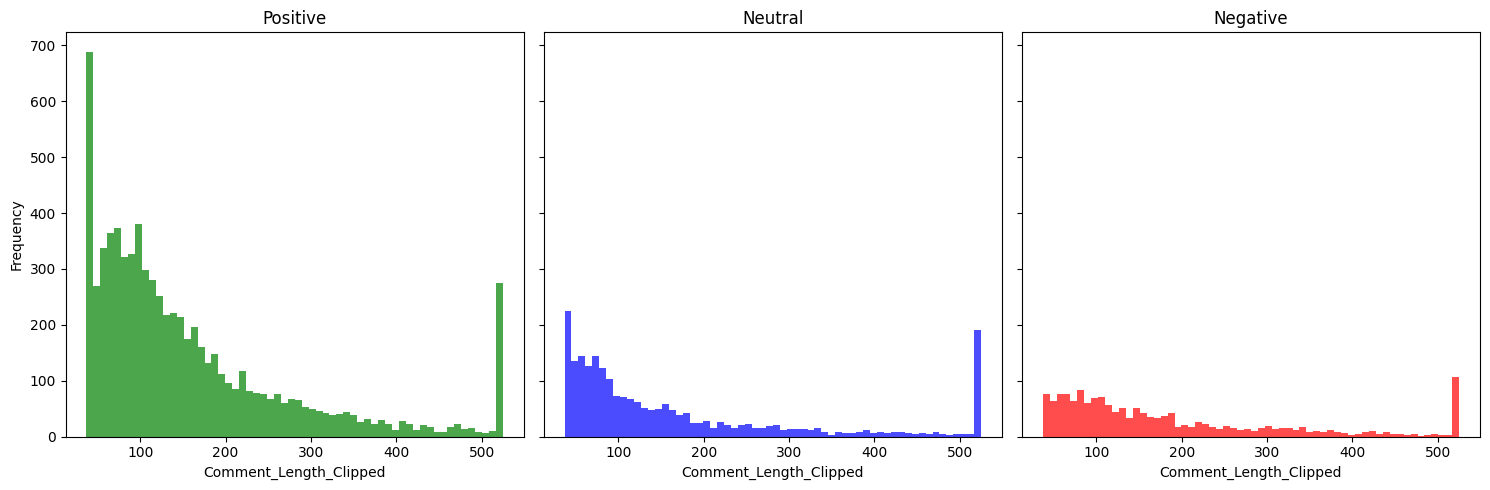

In [142]:
# Podział danych według sentymentu
positive = df[df['Sentiment'] == 'positive']
negative = df[df['Sentiment'] == 'negative']
neutral = df[df['Sentiment'] == 'neutral']

# Wyznaczenie wspólnego zakresu dla osi X
min_length = df['Comment_Length_Clipped'].min()
max_length = df['Comment_Length_Clipped'].max()

# Tworzenie figure i subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Histogram dla pozytywnych komentarzy
axes[0].hist(positive['Comment_Length_Clipped'], bins=60, color='green', alpha=0.7, range=(min_length, max_length))
axes[0].set_title('Positive')
axes[0].set_xlabel('Comment_Length_Clipped')
axes[0].set_ylabel('Frequency')

# Histogram dla neutralnych komentarzy
axes[1].hist(neutral['Comment_Length_Clipped'], bins=60, color='blue', alpha=0.7, range=(min_length, max_length))
axes[1].set_title('Neutral')
axes[1].set_xlabel('Comment_Length_Clipped')

# Histogram dla negatywnych komentarzy
axes[2].hist(negative['Comment_Length_Clipped'], bins=60, color='red', alpha=0.7, range=(min_length, max_length))
axes[2].set_title('Negative')
axes[2].set_xlabel('Comment_Length_Clipped')

# Optymalizacja wyglądu
plt.tight_layout()
plt.show()

Widać, że po zastąpieniu ekstremalnie długich komentarzy górną granicą, rozkłady dla pozytywnego sentymentu i neutralnego są do siebie bardzo zbliżone, natomiast rozkład dla negatywnego sentymentu jest nieco inny. Widać, że komentarze negatywne są z reguły dłuższe, w przeciwieństwie do pozytywnych i neutralnych. Pozytywne komentarze są najczęsciej krótkie, neutralne są krótkie lub bardzo długie. 

## Badanie zmiennej "Starts_with_I"

<Axes: xlabel='Sentiment', ylabel='Count'>

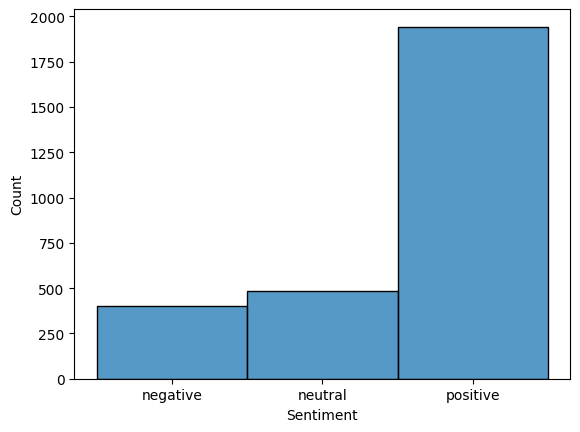

In [143]:
sentiment_order = ["negative", "neutral", "positive"]
df['Sentiment'] = pd.Categorical(df['Sentiment'], categories=sentiment_order, ordered=True)
starts_with_i = df[df["Starts_with_i"] == True]
sns.histplot(starts_with_i['Sentiment'])

In [144]:
starts_with_i.shape[0]/df.shape[0]*100


25.229480438463597

Można zauważyć, że komentarze zaczynające się od "i" to w zdecydowanej większości komentarze pozytywne, co może być przydatne w rozpoznawaniu ich przez model.

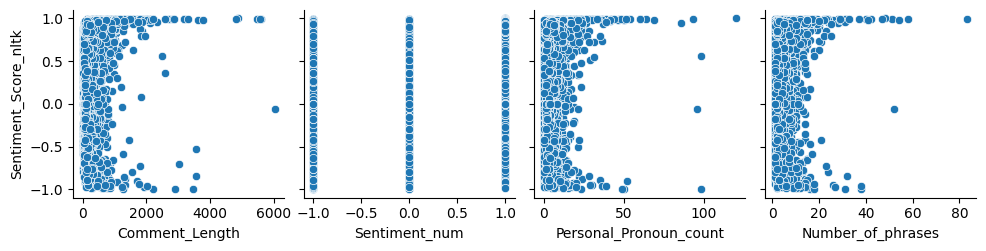

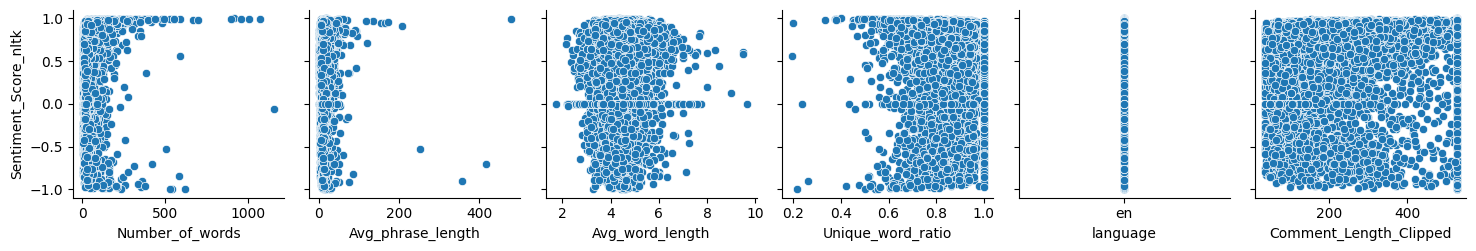

In [145]:
sns.pairplot(df, y_vars="Sentiment_Score_nltk", x_vars=df.columns.values[4:8])
sns.pairplot(df, y_vars="Sentiment_Score_nltk", x_vars=df.columns.values[8:])

plt.show()

Widać, że w przypadkach wyższych wartości Sentiment_score_nltk, tym komentarz ma większe ilości zaimków osobowych (Personal_pronoun_count), jak i większą ilością fraz - większa rozbudowalność komentarza. 

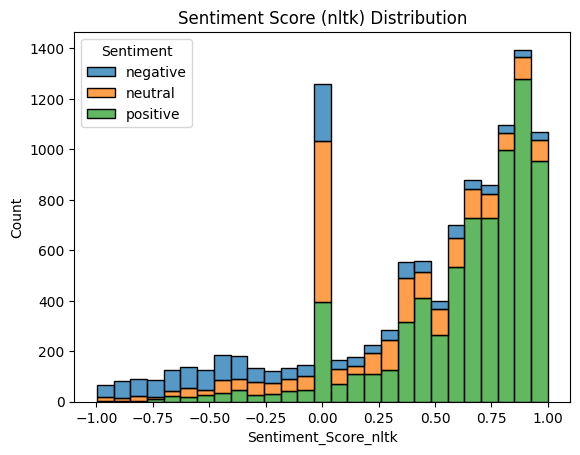

In [146]:
sentiments = sns.histplot(df, x='Sentiment_Score_nltk', hue='Sentiment', multiple='stack')
sentiments.set_title("Sentiment Score (nltk) Distribution")
plt.show()

## Distributions for Sentiment_Score_nltk = 0

In [147]:
zero_score = df[df["Sentiment_Score_nltk"] == 0]
sentiment_order = ["negative", "neutral", "positive"]

zero_score['Sentiment'] = pd.Categorical(zero_score['Sentiment'], categories=sentiment_order, ordered=True)

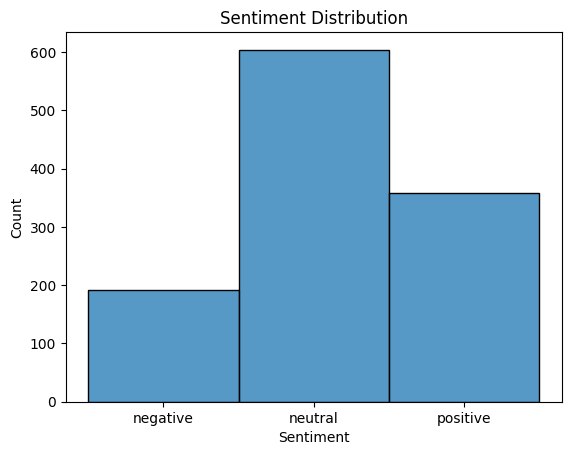

In [148]:
sentiments = sns.histplot(zero_score['Sentiment'], discrete=True)

sentiments.set_title("Sentiment Distribution")
plt.show()

Wiele z komentarzy o Sentiment_Score_nltk = 0 jest pozytywnych, czy negatywnych. Przy tak duzej liczności tej klasy moze to sprawić trudności w jej klasyfikacj 

<Axes: xlabel='Comment_Length_Binned', ylabel='Count'>

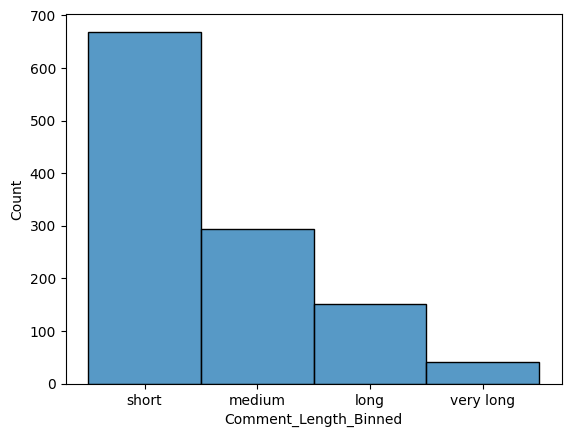

In [149]:
bins = [0, df['Comment_Length'].quantile(0.25), df['Comment_Length'].quantile(0.5), df['Comment_Length'].quantile(0.75), df['Comment_Length'].max()]
labels = ['short', 'medium', 'long', 'very long']
zero_score['Comment_Length_Binned'] = pd.cut(zero_score['Comment_Length'],bins = bins, labels = labels, right = False)
sns.histplot(zero_score['Comment_Length_Binned'])


Widać, że większość komentarzy o zerowym Sentiment_score_nltk to komentarze krótkie.

<Axes: xlabel='Comment_Length', ylabel='Count'>

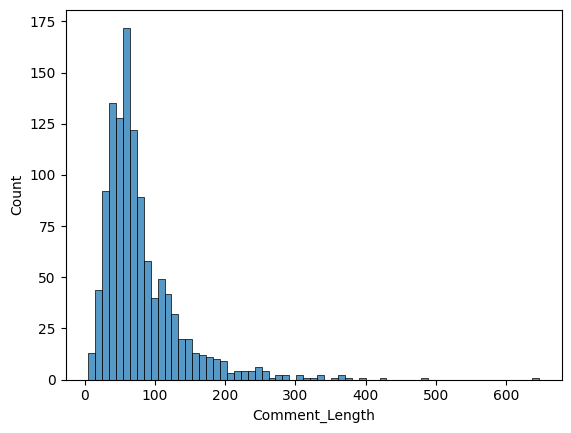

In [150]:
sns.histplot(zero_score, x='Comment_Length')

## Feature correlation matrix

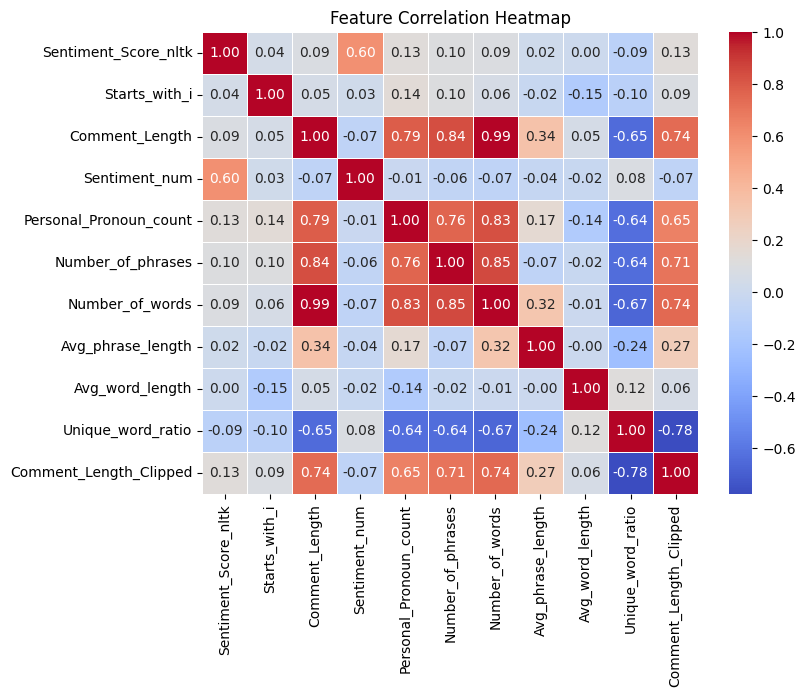

In [151]:
corr_matrix = df.drop(columns=["Comment", "Sentiment", "language"]).corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Balancing the training set

In [ ]:
import pandas as pd
from sklearn.utils import resample

# Check class distribution
print("Before:")
print(df["Sentiment"].value_counts())

# Separate majority and minority classes
train_positive = df[df["Sentiment"] == "positive"]
train_negative = df[df["Sentiment"] == "negative"]
train_neutral = df[df["Sentiment"] == "neutral"]

# Set the desired sample size (same as the majority class)
desired_size = len(train_positive)

# Oversample the minority classes
df_negative_oversampled = resample(train_negative, 
                                   replace=True,  # Sample with replacement
                                   n_samples=desired_size,  # Match majority class size
                                   random_state=42)

df_neutral_oversampled = resample(train_neutral, 
                                  replace=True, 
                                  n_samples=desired_size, 
                                  random_state=42)

# Combine all data back together
df_balanced = pd.concat([train_positive, df_negative_oversampled, df_neutral_oversampled])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new class distribution
print("After:")
print(df_balanced["Sentiment"].value_counts())

Before:
Sentiment
positive    8002
neutral     3246
negative    1637
Name: count, dtype: int64
After:
Sentiment
positive    8002
negative    8002
neutral     8002
Name: count, dtype: int64
